In [44]:
import torch.nn as nn
import torch
import hiddenlayer as hl
import tensorwatch as tw
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset,random_split
# 定义自编码器网络  每个卷积操作 添加一个激活函数操作
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 3), padding=(0, 1)),
            nn.ELU(inplace=True),

            nn.MaxPool2d(kernel_size=(1, 3)),

            nn.Conv2d(16, 32, kernel_size=(1, 3), padding=(0, 1)),
            nn.ELU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=(1, 3), padding=(0, 1)),
            nn.ELU(inplace=True),

            nn.MaxPool2d(kernel_size=(1, 5)),
            
            nn.Conv2d(64, 128, kernel_size=(1, 3), padding=(0, 1)),
            nn.ELU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=(1, 3), padding=(0, 1))
        )
        
        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 128, kernel_size=(1, 3), padding=(0, 1)),
            nn.ELU(inplace=True),
            nn.Upsample(scale_factor=(1,5)),
            nn.ConvTranspose2d(128, 64, kernel_size=(1, 3), padding=(0, 1)),
            nn.ELU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=(1, 3), padding=(0, 1)),
            nn.ELU(inplace=True),
            nn.Upsample(scale_factor=(1,3)),
            nn.ConvTranspose2d(32, 16, kernel_size=(1, 3), padding=(0, 1)),
            nn.ELU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=(1, 3), padding=(0, 1)),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [45]:
# 定义网络对象
model = AutoEncoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda


In [46]:
# 自定义dataSet
class NPZDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.data = []
        self.traces = []
        self.sample = []

        for path in file_paths:
            npz_data = np.load(path)
            self.data.append(npz_data['data'])  # 读取地震数量
            self.traces.append(npz_data['num_traces'])  # 读取地震道数目
            self.sample.append(npz_data['num_samples'])  # 读取采样点数量

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):

        # 通过索引获取数据
        data = self.data[idx]
        data= torch.from_numpy(data).float()  # 转换为张量
        data = data.reshape(1,42,15000)
        traces = self.traces[idx]
        sample = self.sample[idx]

        return data, traces, sample


In [47]:
#  读取指定文件夹的所有npz文件
import os
import numpy as np

folder_path = '../NPZDATA'  # 替换为实际的文件夹路径

file_paths = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.npz'):
        file_paths.append(os.path.join(folder_path, file_name))

npz_dataset = NPZDataset(file_paths)
data, traces, sample = npz_dataset[0]
print(data.shape)  # 输出 (1.42, 15000)


torch.Size([1, 42, 15000])


In [48]:
from torch.utils.data import random_split
# file_paths = ['data1.npz', 'data2.npz', 'data3.npz']

# 创建 NPZDataset的实例 并使用DataLoader进行数据加载
dataset = NPZDataset(file_paths)   ## 将指定的文件夹下面的所有npz文件 读取出来 保存成NPZDATASET

# 计算训练集和测试集的划分大小
dataset_size = len(dataset)
print(dataset_size)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

#  划分数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


#  四维输入 batch_size channel2 height width  1 x 42 x 1 x 15000
#  创建训练集和测试集的数据加载器  DataLoader  batch_size = 1  shuffle 打乱文件顺序
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size = 1,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size = 1,shuffle=True)

681


In [49]:
#  归一化
def normalization(data):
    _range = np.max(data) - np.min(data)

    if _range != 0:
        tem = (data - np.min(data)) / _range
        tem = 2 * tem -1

        return tem
    if _range == 0:
        return np.zeros(data.shape)
    
# 标准化
def standardization(data):
    if np.std(data) == 0:
        return np.zeros(data.shape)
    else:
        return (data - np.mean(data)) / np.std(data)

In [50]:
import torch.nn as nn
loss_fn = nn.MSELoss()  # 损失函数  均方根损失函数
loss_fn = loss_fn.to(device)  # cuda 进行训练
learning_rate = 0.0001 ## 学习率
writer = SummaryWriter("../encoder_train")  # tensorboard
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)  ## 定义优化器
total_train_step = 0  ## 训练步骤数目
total_test_step = 0  ## 测试步骤数目
epoch = 20 ## 迭代次数

# 训练
for epoch in range(epoch):

    #  设置模型为训练模式
    model.train()
    for data,num_traces,num_samples in train_dataloader:

        # print(data.shape)
        # data = data.reshape(1,1,42,15000)
        inputs  = data

        inputs = data.to(device)

        #  将数据输入模型
        outputs = model(inputs)  

        # print(inputs.shape)
        # print("输出结果的形状是{}".format(outputs.shape))

        #  计算损失  对比原始输入和自编码器的输出结果
        loss = loss_fn(outputs,inputs)

        #  先清除梯度
        optimizer.zero_grad()

        #  反向传播
        loss.backward()

        # 优化
        optimizer.step()

        # 训练次数加一
        total_train_step = total_train_step + 1

        if total_train_step % 50 == 0:
            # 绘制训练损失
            writer.add_scalar("Compress_train5",loss.item(),total_train_step)
            print("训练次数：{},Loss{}".format(total_train_step,loss.item()))


    # 测试步骤开始
    model.eval()
    with torch.no_grad():
        # 取出测试数据集的数据
        for data,num_traces,num_samples in test_dataloader:
            inputs  = data
            inputs = data.to(device)
            #  将数据输入模型
            outputs = model(inputs)
             #  计算损失  对比原始输入和自编码器的输出结果
            loss = loss_fn(outputs,inputs) 
            total_test_step = total_test_step + 1
            if total_test_step % 50 == 0:
                writer.add_scalar("Compress_test5",loss.item(),total_test_step)
                print("测试次数：{},Loss{}".format(total_test_step,loss.item()))





训练次数：50,Loss0.09357503801584244
训练次数：100,Loss0.07563536614179611
训练次数：150,Loss0.06001104786992073
训练次数：200,Loss0.047764942049980164
训练次数：250,Loss0.03838959336280823
训练次数：300,Loss0.031387295573949814
训练次数：350,Loss0.024699857458472252
训练次数：400,Loss0.01990143209695816
训练次数：450,Loss0.01557264942675829
训练次数：500,Loss0.012396002188324928
测试次数：50,Loss0.01123843900859356
测试次数：100,Loss0.012038988061249256
训练次数：550,Loss0.010146165266633034
训练次数：600,Loss0.008076842874288559
训练次数：650,Loss0.006231668870896101
训练次数：700,Loss0.005032654851675034
训练次数：750,Loss0.005637271795421839
训练次数：800,Loss0.00374067691154778
训练次数：850,Loss0.003079239744693041
训练次数：900,Loss0.0029662190936505795
训练次数：950,Loss0.0018474127864465117
训练次数：1000,Loss0.00224984809756279
训练次数：1050,Loss0.0017779315821826458
测试次数：150,Loss0.0011375610483810306
测试次数：200,Loss0.00234316848218441
测试次数：250,Loss0.002048641676083207
训练次数：1100,Loss0.0014617746928706765
训练次数：1150,Loss0.001257902360521257
训练次数：1200,Loss0.0011776130413636565
训练次数：1250,Loss0

In [51]:
# 绘制原始的波形
data_test1, traces, sample = npz_dataset[0]
data_test1 = data_test1.unsqueeze(0)
print(data_test1.shape)

torch.Size([1, 1, 42, 15000])


In [52]:

torch.save(model.state_dict(),"model_autoCoder.pth")  # 保存模型

In [53]:
#  加载模型
loaded_model = AutoEncoder()
loaded_model.load_state_dict(torch.load("model_autoCoder.pth"))
loaded_model.eval()


data_test1, traces, sample = npz_dataset[0]
data_test1 = data_test1.unsqueeze(0)
print(data_test1.shape)

#  使用加载的模型进行压缩数据
with torch.no_grad():
    compressed_data1 = loaded_model.encoder(data_test1)
    resconstructed_data1 = loaded_model.decoder(compressed_data1)

print(compressed_data1.shape)
print(resconstructed_data1.shape)

torch.Size([1, 1, 42, 15000])
torch.Size([1, 1, 42, 1000])
torch.Size([1, 1, 42, 15000])


In [54]:
#  将压缩之后的数据转换为numpy数组

compressed_data1 = compressed_data1.cpu().numpy()

import numpy as np
# 计算原始数据的信噪比

original_data = data_test1.cpu().numpy()
resconstructed_data1 = resconstructed_data1.cpu().numpy()

noise = original_data - resconstructed_data1

snr = 10 * np.log10(np.linalg.norm(original_data) / np.linalg.norm(noise))

print("压缩之后的segy数据信噪比SNR是{}db".format(snr))

压缩之后的segy数据信噪比SNR是-0.06482092663645744db


In [55]:
# 绘制原始的segy图像

data_original = original_data.reshape(42,15000)
print(data_original)



data_compress = resconstructed_data1.reshape(42,15000)
print(data_compress.shape)
print(data_compress)

[[ 0.0000000e+00  8.5614880e-20  1.7807189e-18 ...  3.1750139e-03
   3.2564579e-03  3.3338720e-03]
 [ 0.0000000e+00  8.5614880e-20  1.7807189e-18 ...  4.7142957e-03
   4.8886784e-03  5.0563831e-03]
 [ 0.0000000e+00  9.9247190e-21  2.0642597e-19 ... -6.8788305e-03
  -6.7778202e-03 -6.6792956e-03]
 ...
 [ 0.0000000e+00 -1.5117918e-20 -3.1444022e-19 ... -4.0589171e-03
  -4.4936291e-03 -4.9230549e-03]
 [ 0.0000000e+00  7.2904811e-20  1.5284427e-18 ... -1.8659882e-02
  -1.8882984e-02 -1.9101935e-02]
 [ 0.0000000e+00  7.2904811e-20  1.4680335e-18 ... -2.9588498e-03
  -3.0454029e-03 -3.1322627e-03]]
(42, 15000)
[[ 0.05206895 -0.08861938 -0.01451778 ... -0.0056856  -0.0618203
  -0.2517258 ]
 [ 0.05206898 -0.08861944 -0.01451781 ... -0.00568387 -0.06181926
  -0.25172412]
 [ 0.05206895 -0.08861938 -0.01451778 ... -0.0056338  -0.06177655
  -0.2516993 ]
 ...
 [ 0.05206892 -0.08861944 -0.01451775 ... -0.00568852 -0.0618203
  -0.25173193]
 [ 0.05206898 -0.08861944 -0.01451781 ... -0.00560591 -0.0617

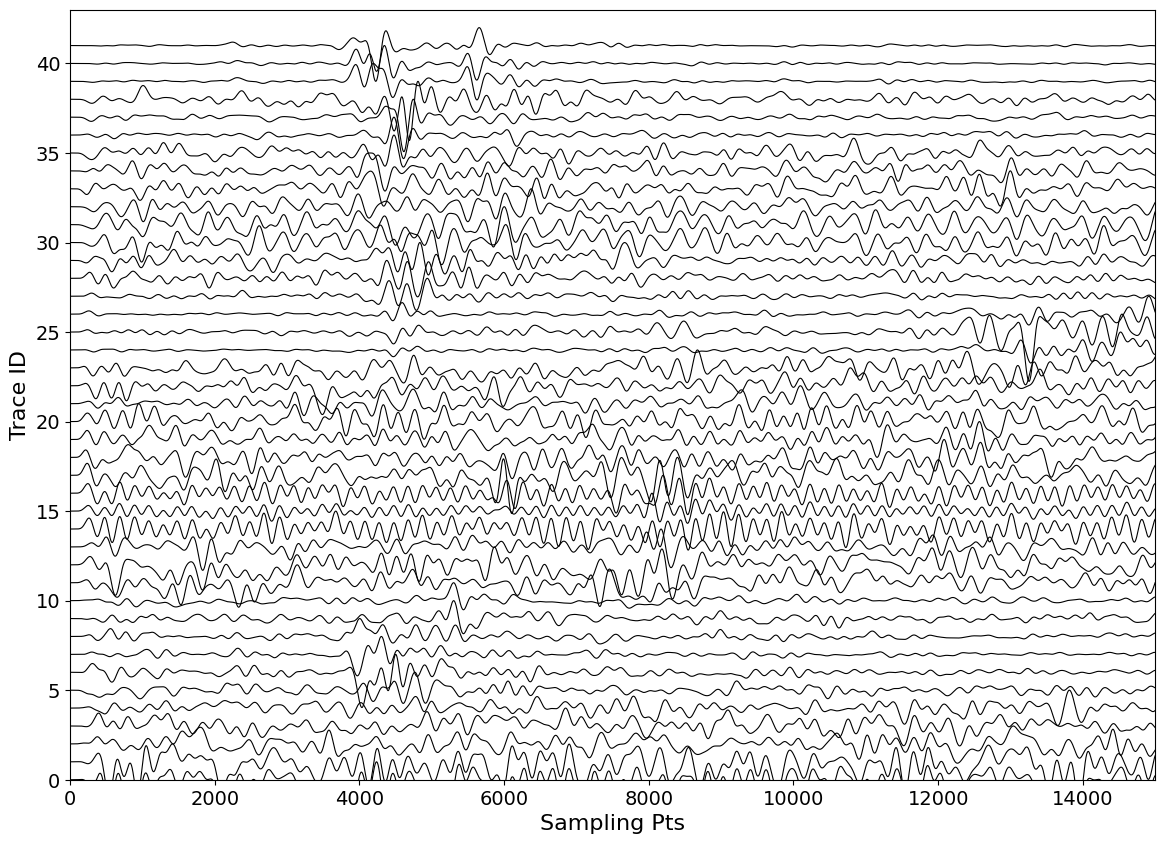

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,10))
counter = 0
for i in range(len(data_original)):
    plt.plot(counter + data_original[i,:] / (1e-12 + max(data_original[i,:])),'k',lw=0.8)
    counter += 1

plt.xlim([0,data_original.shape[-1]])
plt.xticks(fontsize = 14)
plt.xlabel('Sampling Pts',fontsize=16)
plt.ylim([0,data_original.shape[0] + 1])
plt.yticks(fontsize = 14)
plt.ylabel('Trace ID',fontsize = 16)
plt.show()


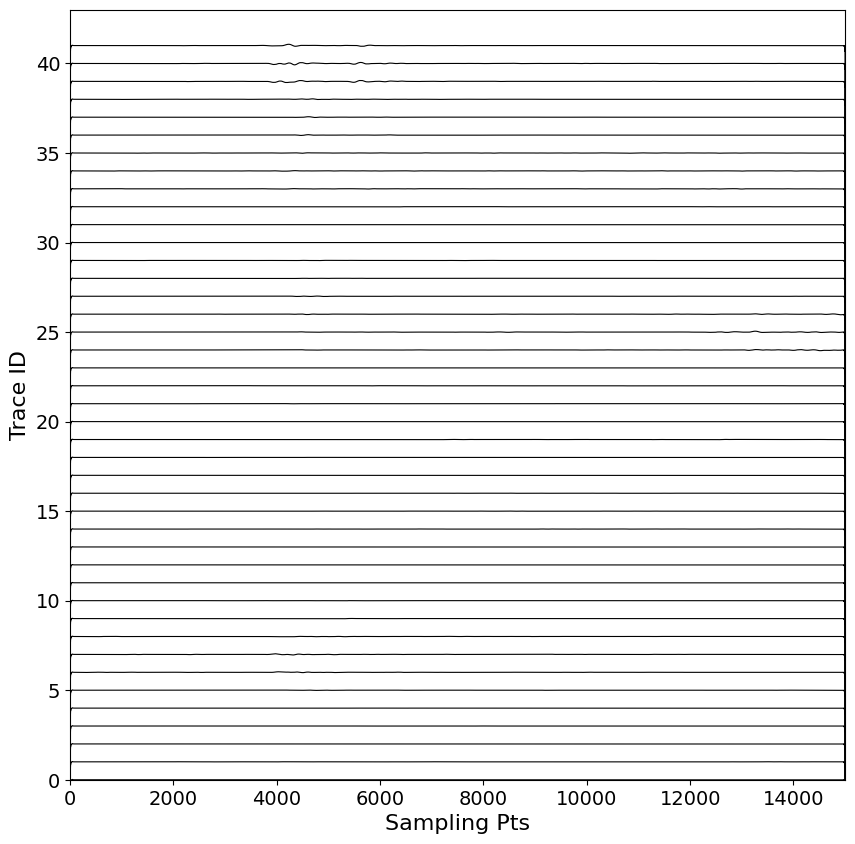

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
counter = 0
for i in range(len(data_compress)):
    plt.plot(counter + data_compress[i,:] / (1e-12 + max(data_compress[i,:])),'k',lw=0.8)
    counter += 1

plt.xlim([0,data_compress.shape[-1]])
plt.xticks(fontsize = 14)
plt.xlabel('Sampling Pts',fontsize=16)
plt.ylim([0,data_compress.shape[0] + 1])
plt.yticks(fontsize = 14)
plt.ylabel('Trace ID',fontsize = 16)
plt.show()


In [58]:
for data in data_original:
    print(data)

[0.0000000e+00 8.5614880e-20 1.7807189e-18 ... 3.1750139e-03 3.2564579e-03
 3.3338720e-03]
[0.0000000e+00 8.5614880e-20 1.7807189e-18 ... 4.7142957e-03 4.8886784e-03
 5.0563831e-03]
[ 0.0000000e+00  9.9247190e-21  2.0642597e-19 ... -6.8788305e-03
 -6.7778202e-03 -6.6792956e-03]
[ 0.0000000e+00 -2.1555224e-21 -9.3159323e-20 ... -1.2796279e-03
 -1.3520867e-03 -1.4230108e-03]
[ 0.0000000e+00 -2.1555224e-21 -3.2752850e-20 ... -3.4686897e-03
 -3.3704289e-03 -3.2684586e-03]
[ 0.0000000e+00 -7.6675307e-20 -1.5343753e-18 ...  7.6232539e-03
  7.4785687e-03  7.3338281e-03]
[-7.6675307e-20 -1.7520215e-18 -1.9540173e-17 ...  9.8116780e-03
  9.8965764e-03  9.9756280e-03]
[0.0000000e+00 3.2201619e-19 6.6035867e-18 ... 2.0112591e-02 2.0039918e-02
 1.9956253e-02]
[0.0000000e+00 1.1582188e-19 2.3727550e-18 ... 1.9036092e-02 1.9157242e-02
 1.9271106e-02]
[3.0844825e-20 6.9027933e-19 7.6459141e-18 ... 1.2031534e-02 1.2168071e-02
 1.2300588e-02]
[3.0844825e-20 6.5403465e-19 6.9407873e-18 ... 1.0797022e-02

In [59]:
for data in data_compress:
    print(data)

[ 0.05206895 -0.08861938 -0.01451778 ... -0.0056856  -0.0618203
 -0.2517258 ]
[ 0.05206898 -0.08861944 -0.01451781 ... -0.00568387 -0.06181926
 -0.25172412]
[ 0.05206895 -0.08861938 -0.01451778 ... -0.0056338  -0.06177655
 -0.2516993 ]
[ 0.05206898 -0.08861944 -0.01451775 ... -0.00567448 -0.06181023
 -0.25172168]
[ 0.05206895 -0.08861935 -0.01451775 ... -0.00565004 -0.06179008
 -0.25170824]
[ 0.05206898 -0.08861941 -0.01451781 ... -0.005721   -0.06184918
 -0.25174564]
[ 0.05206898 -0.08861941 -0.01451781 ... -0.00571528 -0.06184545
 -0.25174055]
[ 0.05206889 -0.08861941 -0.01451778 ... -0.00577623 -0.0618968
 -0.251772  ]
[ 0.05206895 -0.0886195  -0.01451784 ... -0.00575253 -0.06187725
 -0.251759  ]
[ 0.05206898 -0.0886195  -0.01451781 ... -0.00572079 -0.06185031
 -0.2517432 ]
[ 0.05206895 -0.08861938 -0.01451778 ... -0.00572324 -0.06185207
 -0.25174505]
[ 0.05206898 -0.08861944 -0.01451775 ... -0.00565836 -0.06179741
 -0.25171164]
[ 0.05206898 -0.0886195  -0.01451787 ... -0.00567162 -